In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import glob

import bvcopula

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
path = '/home/nina/models'

In [14]:
import warnings
import sys
import traceback

def _get_copula(likelihood, f, sample_size): #likelihood method
    thetas, mixes = likelihood.gplink_function(f)
    thetas = thetas.expand(sample_size+thetas.shape)
    mixes = mixes.expand(sample_size+mixes.shape)
    thetas = torch.einsum('ijk->jki', thetas) # now: [copulas, positions, samples]
    mixes = torch.einsum('ijk->jki', mixes)
    copulas = [lik.copula for lik in likelihood.likelihoods]
    rotations = [lik.rotation for lik in likelihood.likelihoods]
    return likelihood.copula(thetas,mixes,copulas,rotations=rotations)
    
def _entropy_given_params(copula, alpha=0.05, sem_tol=1e-3): #copula_method
        # Gaussian confidence interval for sem_tol and level alpha
        conf = torch.erfinv(torch.tensor([1. - alpha]))
        sem = torch.ones(copula.theta.shape[1])*float('inf')
        ent = torch.zeros(copula.theta.shape[1])
        var_sum = torch.zeros(copula.theta.shape[1])
        log2 = torch.tensor([2.]).log()
        k = 0
        mc_size = copula.theta.shape[-1]
        with torch.no_grad():
            while torch.all(sem >= sem_tol):
                # Generate samples
                samples = copula.rsample()
                assert samples.dim()==3 # [conditioning_variable, samples, 2]
                logp = copula.log_prob(samples)
                assert torch.all(logp==logp)
                assert torch.all(logp.abs()!=float("inf")) #otherwise make masked tensor below
                log2p = logp / log2 #maybe should check for inf 2 lines earlier
                k += 1
                # Monte-Carlo estimate of entropy
                ent += (-log2p.mean(dim=(-1)) - ent) / k
                # Estimate standard error
                var_sum += ((-log2p.t() - ent) ** 2).sum()
                sem = conf * (var_sum / (k * mc_size * (k * mc_size - 1))).pow(.5)
        return ent, sem
    
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
    
def measure_MI(n1,n2,likelihoods,device,cond_mc_size=20,samp_mc_size=100000):
    get_weights_filename = glob.glob('{}/{}/model_{}-{}.pth'.format(path,exp_pref,n1,n2))
    print(get_weights_filename)
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
        interv=torch.tensor([0.,1.])
        points = torch.empty(size=torch.Size([cond_mc_size])).to(device=device)
        points = points.uniform_(*interv)
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        with torch.no_grad():
            fs = model(points).rsample(torch.Size([3])) #[samples_f, copulas, positions]
        #copula = _get_copula(model.likelihood, fs, sample_size = torch.Size([samp_mc_size]))
        #MI, sem = _entropy_given_params(copula)
        MIs = []
        for f in fs: #TODOL Parallelize this part!
            copula = _get_copula(model.likelihood, f, sample_size = torch.Size([samp_mc_size]))
            MI, _ = _entropy_given_params(copula)
            MIs.append(MI)
        MIs = torch.stack(MIs)
        print(MIs.mean(dim=0),MIs.std(dim=0))
    else:
        print('Weights file {} not found.'.format(get_weights_filename))

warnings.showwarning = warn_with_traceback
%time measure_MI(-5, -4, [bvcopula.FrankCopula_Likelihood()], torch.device('cpu'))

['/home/nina/models/ST263_Day4/model_-5--4.pth']
tensor([-0.0870, -0.0858, -0.0878, -0.0576, -0.0835, -0.0896, -0.0354, -0.0445,
        -0.0884, -0.0443, -0.0888, -0.0876, -0.0594, -0.0366, -0.0885, -0.0614,
        -0.0634, -0.0872, -0.0433, -0.0426]) tensor([0.0092, 0.0097, 0.0052, 0.0101, 0.0096, 0.0086, 0.0019, 0.0050, 0.0059,
        0.0049, 0.0072, 0.0078, 0.0075, 0.0053, 0.0068, 0.0082, 0.0072, 0.0078,
        0.0090, 0.0082])
CPU times: user 20min 5s, sys: 27.2 s, total: 20min 33s
Wall time: 1min 11s


(-0.15, 0)

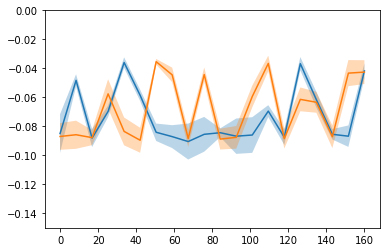

In [16]:
y = np.array([-0.0850, -0.0483, -0.0881, -0.0697, -0.0360, -0.0586, -0.0841, -0.0871,
        -0.0905, -0.0855, -0.0844, -0.0868, -0.0860, -0.0695, -0.0875, -0.0368,
        -0.0616, -0.0855, -0.0868, -0.0418])
dy = np.array([0.0133, 0.0042, 0.0062, 0.0040, 0.0036, 0.0039, 0.0060, 0.0079, 0.0124,
        0.0120, 0.0030, 0.0122, 0.0123, 0.0041, 0.0053, 0.0046, 0.0054, 0.0036,
        0.0074, 0.0052])
y1 = np.array([-0.0870, -0.0858, -0.0878, -0.0576, -0.0835, -0.0896, -0.0354, -0.0445,
        -0.0884, -0.0443, -0.0888, -0.0876, -0.0594, -0.0366, -0.0885, -0.0614,
        -0.0634, -0.0872, -0.0433, -0.0426])
dy1 = np.array([0.0092, 0.0097, 0.0052, 0.0101, 0.0096, 0.0086, 0.0019, 0.0050, 0.0059,
        0.0049, 0.0072, 0.0078, 0.0075, 0.0053, 0.0068, 0.0082, 0.0072, 0.0078,
        0.0090, 0.0082])
plt.plot(np.linspace(0,160,len(y)),y)
plt.fill_between(np.linspace(0,160,len(y)),y-dy,y+dy, alpha=0.3)
plt.plot(np.linspace(0,160,len(y1)),y1)
plt.fill_between(np.linspace(0,160,len(y1)),y1-dy1,y1+dy1, alpha=0.3)
plt.ylim(-.15,0)